In [126]:
import cv2
import numpy as np
import json
import os
import base64
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from io import BytesIO
import ffmpeg
import shutil


def extract_frames(video_path, output_folder, interval):
    """Extract frames from video at specified interval"""
    os.makedirs(output_folder, exist_ok=True)
    ffmpeg.input(video_path, ss=0).output(
        f"{output_folder}/frame_%03d.png", vf=f"fps=1/{interval}"
    ).run()


def create_tracking_composite(
    json_file_path,
    video_path,
    output_composite_file_name,
    frames=[0, None],
    frames_folder="temp_composite_frames",
    output_folder="composite_output",
    output_filename="composite_visualization.mp4",
    frame_rate=10,
    show_progress=False,
    frame_interval=0.6,
    smoothing_window=3,
):
    for filename in os.listdir(frames_folder):
        file_path = os.path.join(frames_folder, filename)
        if os.path.isdir(file_path):
            shutil.rmtree(file_path)
        else:
            os.remove(file_path)
    # Create output and frames directories
    os.makedirs(output_folder, exist_ok=True)

    # Extract frames at the specified interval
    print("Extracting frames from video...")
    extract_frames(video_path, frames_folder, frame_interval)
    print("Frame extraction complete.")

    # Load the tracking data
    with open(json_file_path, "r") as f:
        tracking_data = json.load(f)

    if frames[1] is None:
        frames[1] = len(tracking_data["frames"]) - 1
    tracking_data["frames"] = tracking_data["frames"][frames[0] : frames[1]]

    # Get a sample frame to determine dimensions
    sample_frame_path = os.path.join(frames_folder, "frame_001.png")
    sample_frame = cv2.imread(sample_frame_path)
    height, width = sample_frame.shape[:2]

    # Create video writer for output
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_out = cv2.VideoWriter(
        os.path.join(output_folder, output_filename),
        fourcc,
        frame_rate,
        (width, height),
    )

    # Extract all tip positions for trajectory plot
    all_tip_positions = []
    for frame_data in tracking_data["frames"]:
        tip_pos = frame_data["tip_position"]
        all_tip_positions.append((tip_pos["x"], tip_pos["y"]))

    tip_array = np.array(all_tip_positions)
    # # At the beginning of your function, create a white canvas
    # composite = np.ones((height, width, 3), dtype=np.uint8) * 255  # White background
    # composite = np.zeros((height, width, 3), dtype=np.uint8)  # Black background
    composite = np.ones((height, width, 3), dtype=np.uint8) * 127  # Gray background

    # Add this function to calculate moving average for tip positions
    def moving_average(positions, window):
        """Apply moving average smoothing to a list of positions"""
        # Convert list of (x,y) tuples or dicts to separate x and y arrays
        if isinstance(positions[0], dict):
            x_vals = [pos["x"] for pos in positions]
            y_vals = [pos["y"] for pos in positions]
        else:
            x_vals = [pos[0] for pos in positions]
            y_vals = [pos[1] for pos in positions]

        # Apply moving average to x and y separately
        x_smooth = []
        y_smooth = []

        for i in range(len(x_vals)):
            # Skip smoothing for first and last (window//2) points
            if i < window // 2 or i >= len(x_vals) - window // 2:
                x_smooth.append(x_vals[i])
                y_smooth.append(y_vals[i])
                continue

            # Calculate window boundaries for center points
            start = i - window // 2
            end = i + window // 2 + 1

            # Calculate averages
            x_avg = sum(x_vals[start:end]) / (end - start)
            y_avg = sum(y_vals[start:end]) / (end - start)

            x_smooth.append(int(x_avg))
            y_smooth.append(int(y_avg))

        # Return as list of tuples
        return list(zip(x_smooth, y_smooth))

    # Calculate smoothed tip positions before the main loop
    if len(all_tip_positions) > 0:
        # Get smoothed tip positions
        smoothed_tip_positions = moving_average(
            all_tip_positions, window=smoothing_window
        )
        smoothed_tip_array = np.array(smoothed_tip_positions)
    else:
        smoothed_tip_array = tip_array.copy()

    # Process each frame
    for i, frame_data in enumerate(tracking_data["frames"]):
        if i < frames[0] or (frames[1] is not None and i > frames[1] + 1):
            continue
        frame_index = frame_data["frame_index"]
        if show_progress and i % 10 == 0:
            print(f"Processing frame {frame_index}/{len(tracking_data['frames'])}")

        # Load frame directly from extracted frames
        frame_path = os.path.join(frames_folder, f"frame_{frame_index + 1:03d}.png")

        if os.path.exists(frame_path):
            frame = cv2.imread(frame_path)
        else:
            print(f"Error: Frame file not found: {frame_path}")
            continue

        # Convert frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Decode the mask from base64
        mask_base64 = frame_data["mask"]
        mask_bytes = base64.b64decode(mask_base64)
        mask_array = np.frombuffer(mask_bytes, dtype=np.uint8)
        binary_mask = cv2.imdecode(mask_array, cv2.IMREAD_GRAYSCALE)

        # Apply mask to the frame
        masked_frame = cv2.bitwise_and(frame_rgb, frame_rgb, mask=binary_mask)

        # Add the masked frame to the composite
        mask_indices = binary_mask > 0
        composite[mask_indices] = masked_frame[mask_indices]

        # Create outline by finding the contours of the mask
        contours, _ = cv2.findContours(
            binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Get current tip position (use smoothed position)
        current_tip = smoothed_tip_array[i]
        tip_x, tip_y = current_tip

        # Create a copy of the composite for this frame
        frame_composite = composite.copy()

        # Draw all tip positions up to current frame with gray to black gradient
        current_tip_array = smoothed_tip_array[: i + 1]

        # Draw trajectory line
        if len(current_tip_array) > 1:
            for j in range(len(current_tip_array) - 1):
                pt1 = tuple(current_tip_array[j])
                pt2 = tuple(current_tip_array[j + 1])

                # Use color gradient along the path (blue to red)
                color_factor = j / (len(current_tip_array) - 1)
                line_color = (
                    int(255 * color_factor),  # Red
                    0,  # Green
                    int(255 * (1 - color_factor)),  # Blue
                )

                cv2.line(frame_composite, pt1, pt2, line_color, 2)

        # Draw current position with a larger circle
        cv2.circle(
            frame_composite,
            (tip_x, tip_y),
            5,
            (0, 255, 0),  # Keep the current position green for visibility
            -1,
        )
        # Write to video
        video_out.write(cv2.cvtColor(frame_composite, cv2.COLOR_RGB2BGR))

        # Display progress if requested
        if show_progress:
            plt.figure(figsize=(10, 8))
            plt.imshow(frame_composite)
            plt.title(f"Composite Frame {i+1}")
            plt.axis("off")
            plt.draw()
            plt.pause(0.01)
            plt.close()

    # Release resources
    video_out.release()

    final_composite = composite.copy()
    if len(smoothed_tip_array) > 1:
        for j in range(len(smoothed_tip_array) - 1):
            if j < frames[0] or (frames[1] is not None and j > frames[1]):
                continue
            pt1 = tuple(smoothed_tip_array[j])
            pt2 = tuple(smoothed_tip_array[j + 1])

            # Use color gradient along the path (blue to red)
            color_factor = (j - frames[0]) / (frames[1] - frames[0] - 1)
            line_color = (
                int(255 * color_factor),  # Red
                0,  # Green
                int(255 * (1 - color_factor)),  # Blue
            )

            cv2.line(final_composite, pt1, pt2, line_color, 2)

            # Add a subtle marker ("-") at each data point
            # Draw a small horizontal line at each point
            marker_length = 10  # Length of the "-" marker in pixels
            x, y = pt1
            cv2.line(
                final_composite,
                (x - marker_length // 2, y),
                (x + marker_length // 2, y),
                line_color,  # Use same color as the trajectory
                1,  # Thin line for subtlety
            )

        x, y = smoothed_tip_array[-1]
        # # Don't forget the last point
        # if frames[1] is None:
        #      x, y = smoothed_tip_array[-1]
        # elif frames[1] < len(smoothed_tip_array) - 1:
        #     x, y = smoothed_tip_array[frames[1] + 1]
        last_color = (255, 0, 0)  # Red for the last point
        cv2.line(
            final_composite,
            (x - marker_length // 2, y),
            (x + marker_length // 2, y),
            last_color,
            1,
        )

    # Show final result
    plt.figure(figsize=(12, 10))
    plt.imshow(final_composite)
    plt.title("Final Composite with Complete Smoothed Trajectory")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, output_composite_file_name), dpi=300)

    # print(f"Composite visualization completed!")
    # print(f"Output video saved to: {os.path.join(output_folder, output_filename)}")
    # print(f"Final composite image saved to: {final_output_path}")

    for filename in os.listdir(frames_folder):
        file_path = os.path.join(frames_folder, filename)
        if os.path.isdir(file_path):
            shutil.rmtree(file_path)
        else:
            os.remove(file_path)
    return final_composite

Extracting frames from video...


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Frame extraction complete.


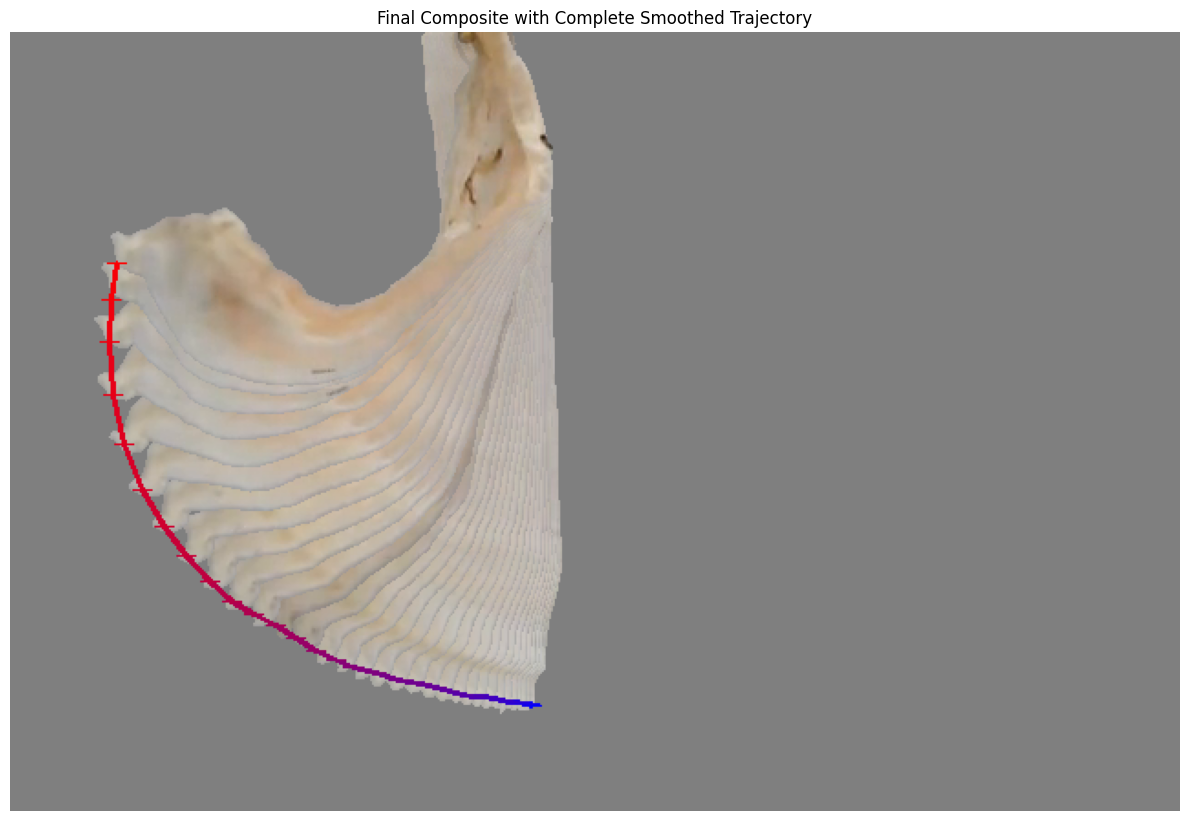

In [129]:
movie_name = "bimorph_idx0_100x"
track = create_tracking_composite(
    json_file_path=f"tracked_trajectories/{movie_name}_json.csv",
    video_path=f"bimorph_videos/{movie_name}.mov",
    output_composite_file_name=f"{movie_name}_composite.pdf",
    show_progress=False,
    frames=[0, 33]
)

Extracting frames from video...


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Frame extraction complete.


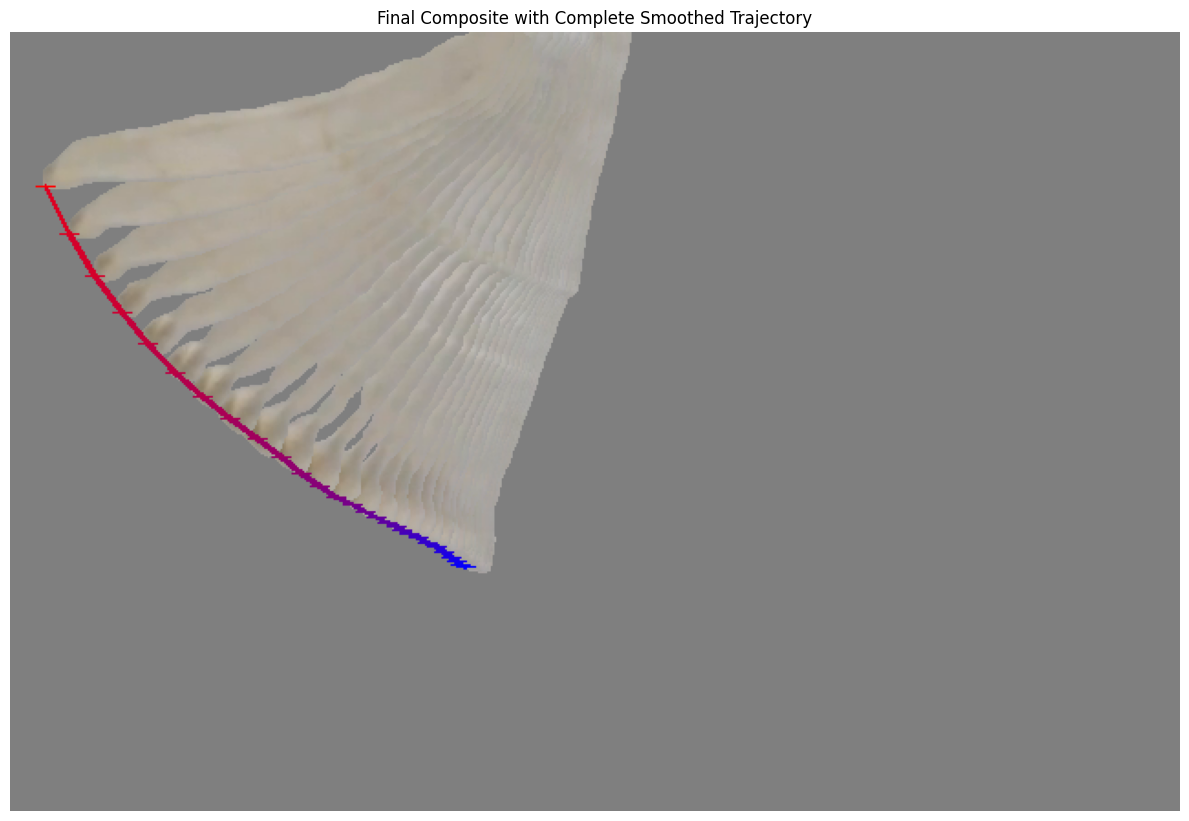

In [128]:
movie_name = "bimorph_idx3_100x"
track = create_tracking_composite(
    json_file_path=f"tracked_trajectories/{movie_name}_json.csv",
    video_path=f"bimorph_videos/{movie_name}.mov",
    output_composite_file_name=f"{movie_name}_composite.pdf",
    show_progress=False,
    frames=[3,None],
)

Extracting frames from video...


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Frame extraction complete.


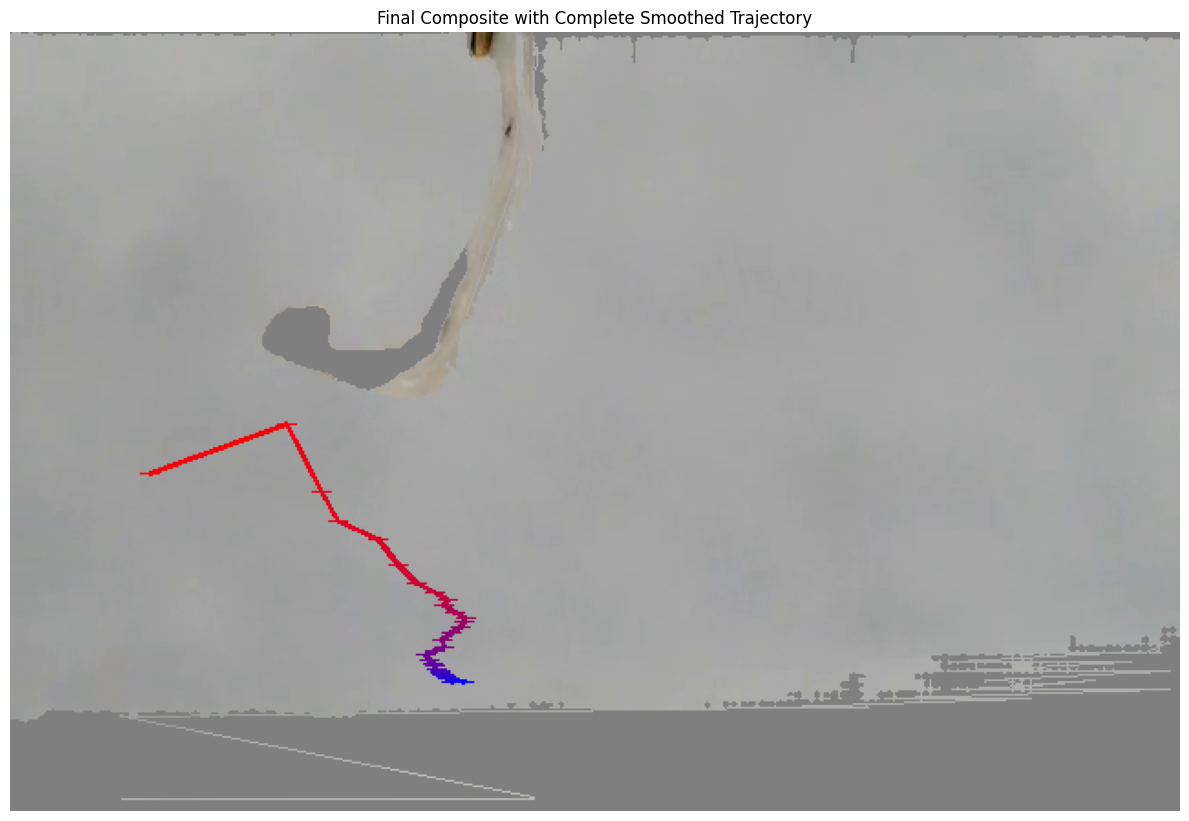

In [102]:
movie_name = "bimorph_idx4_100x"
track = create_tracking_composite(
    json_file_path=f"tracked_trajectories/{movie_name}_json.csv",
    video_path=f"bimorph_videos/{movie_name}.mp4",
    output_composite_file_name=f"{movie_name}_composite.pdf",
    show_progress=False,
)

Extracting frames from video...


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Frame extraction complete.


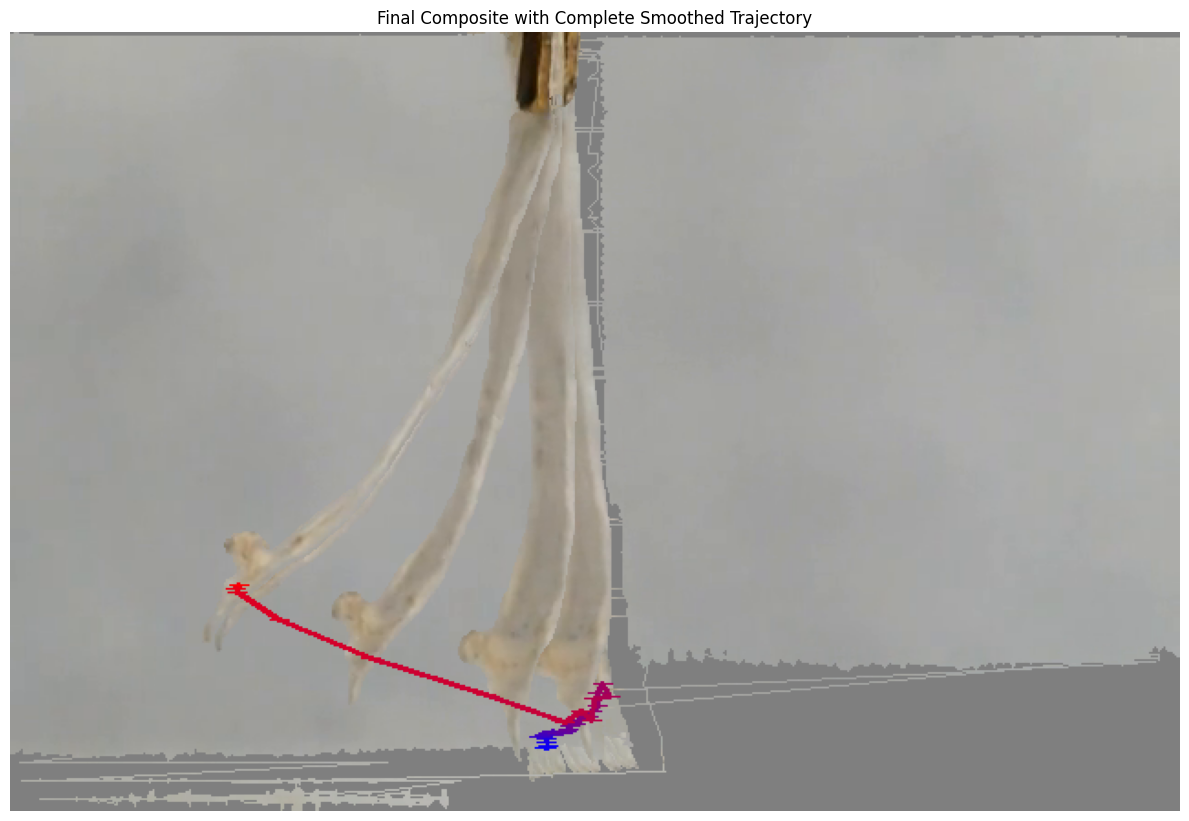

In [133]:
movie_name = "bimorph_idx5_100x"
track = create_tracking_composite(
    json_file_path=f"tracked_trajectories/{movie_name}_json.csv",
    video_path=f"bimorph_videos/{movie_name}.mov",
    output_composite_file_name=f"{movie_name}_composite.pdf",
    show_progress=False,
    frames=[0, None],
)

Extracting frames from video...


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Frame extraction complete.


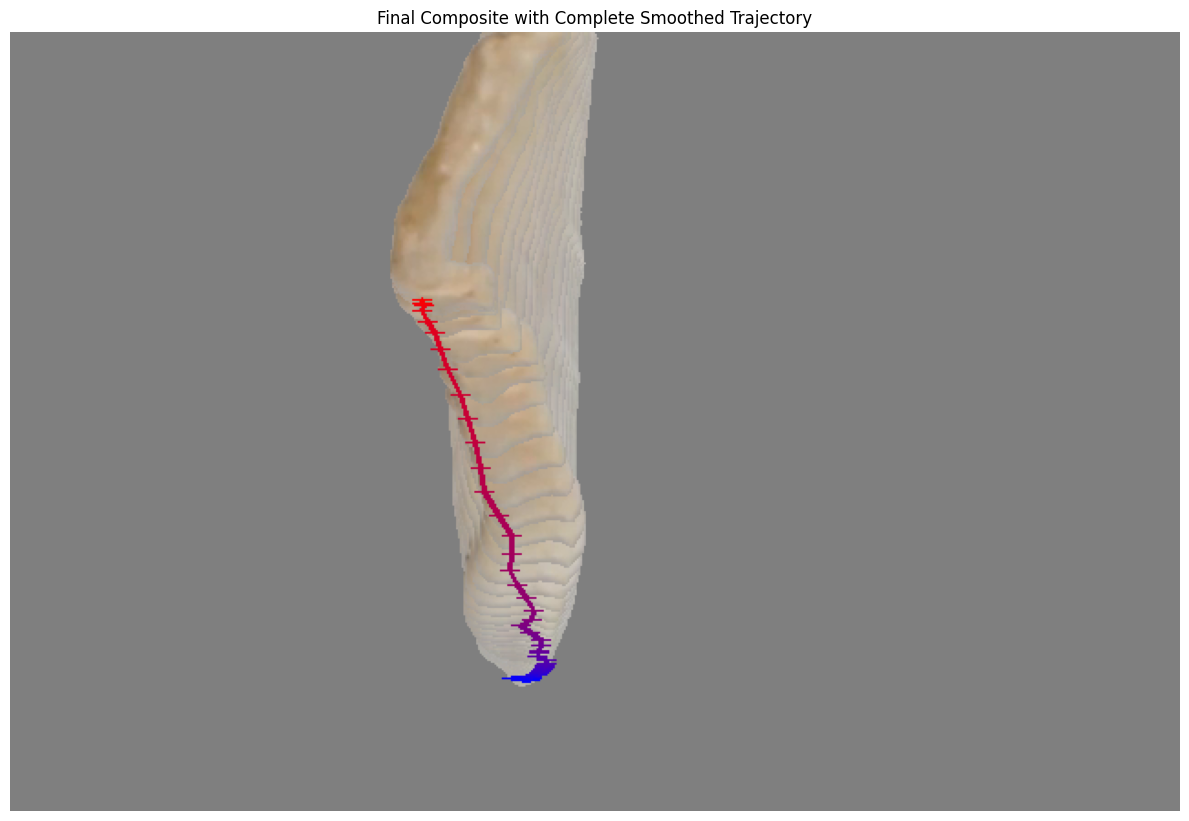

In [92]:
movie_name = "control_idx0_100x"
track = create_tracking_composite(
    json_file_path=f"tracked_trajectories/{movie_name}_json.csv",
    video_path=f"bimorph_videos/{movie_name}.mov",
    output_composite_file_name=f"{movie_name}_composite.pdf",
    show_progress=False,
    frames=(0, 43)
)

Extracting frames from video...


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Frame extraction complete.


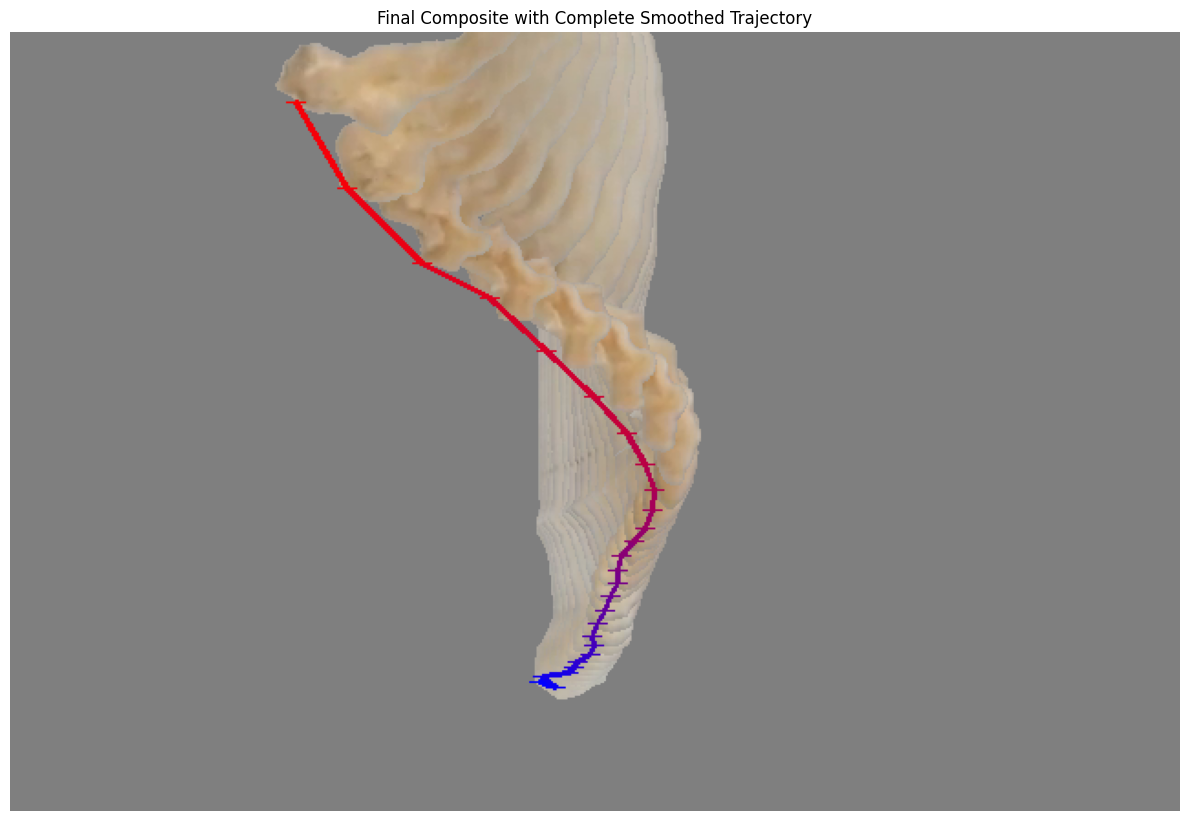

In [110]:
movie_name = "control_idx1_100x"
track = create_tracking_composite(
    json_file_path=f"tracked_trajectories/{movie_name}_json.csv",
    video_path=f"bimorph_videos/{movie_name}.mov",
    output_composite_file_name=f"{movie_name}_composite.pdf",
    show_progress=False,
    frames=[0, None]
)

Extracting frames from video...


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Frame extraction complete.


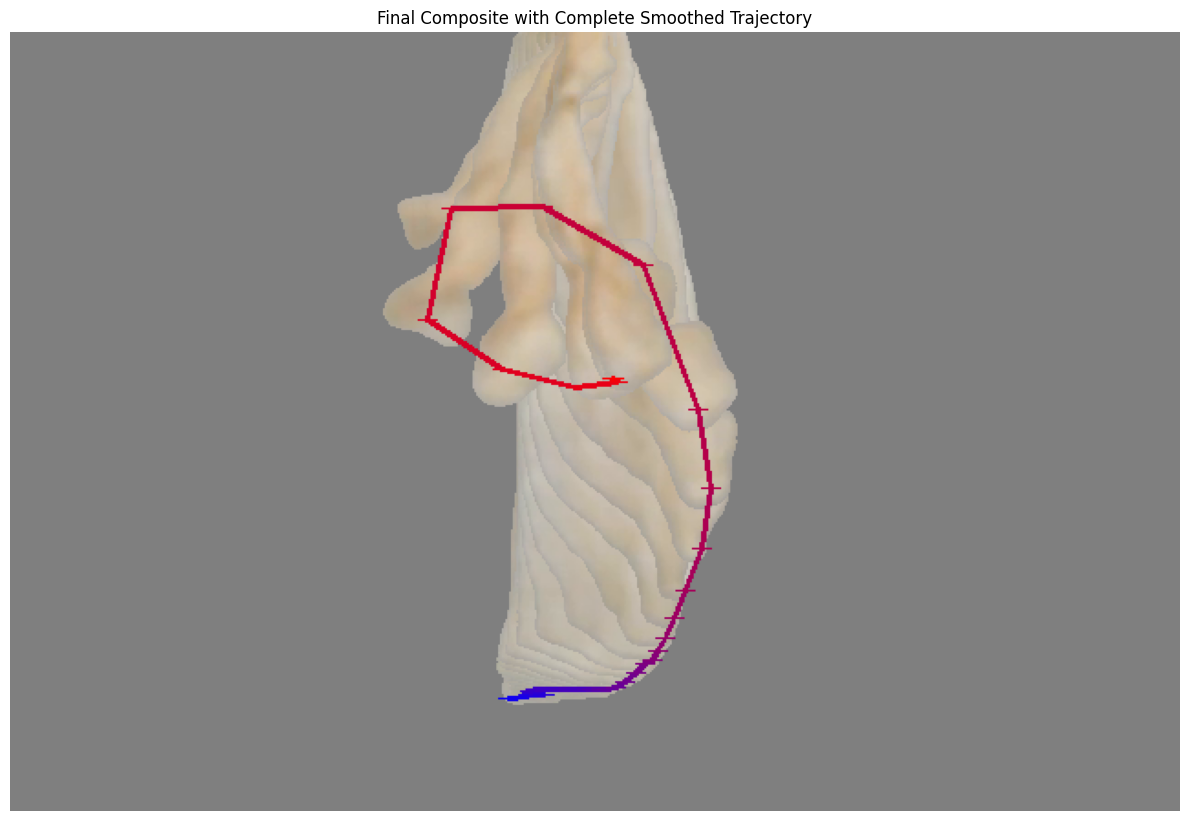

In [121]:
movie_name = "control_idx3_100x"
track = create_tracking_composite(
    json_file_path=f"tracked_trajectories/{movie_name}_json.csv",
    video_path=f"bimorph_videos/{movie_name}.mov",
    output_composite_file_name=f"{movie_name}_composite.pdf",
    show_progress=False,
    frames=[0, 35],
    smoothing_window=3
)

Extracting frames from video...


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Frame extraction complete.


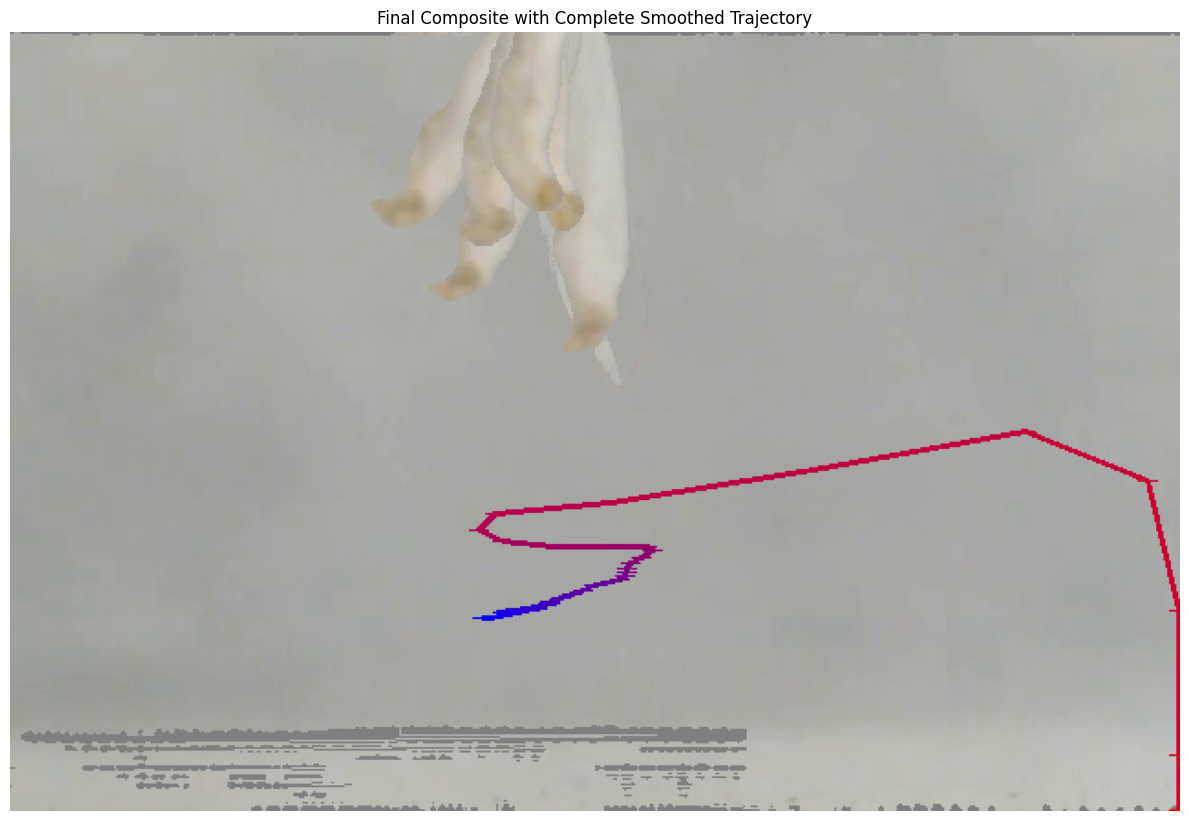

In [136]:
movie_name = "control_idx4_100x"
track = create_tracking_composite(
    json_file_path=f"tracked_trajectories/{movie_name}_json.csv",
    video_path=f"bimorph_videos/{movie_name}.mov",
    output_composite_file_name=f"{movie_name}_composite.pdf",
    show_progress=False,
    frames=[0, None],
)

Extracting frames from video...


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Frame extraction complete.


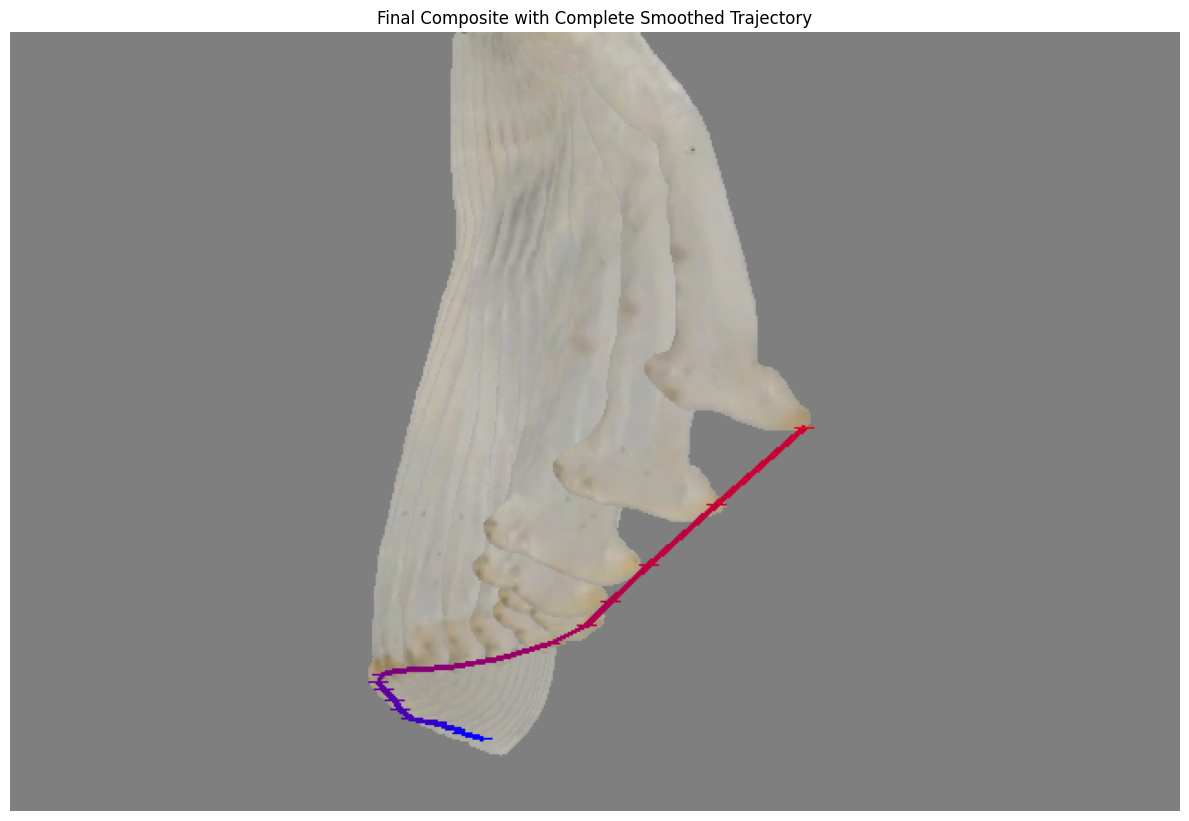

In [140]:
movie_name = "control_idx5_100x"
track = create_tracking_composite(
    json_file_path=f"tracked_trajectories/{movie_name}_json.csv",
    video_path=f"bimorph_videos/{movie_name}.mp4",
    output_composite_file_name=f"{movie_name}_composite.pdf",
    show_progress=False,
    frames=[5, None],
)